참고 코드: 

머신 러닝 교과서 with 파이썬, 사이킷런, 텐서플로 개정 3판
https://github.com/gilbutITbook/080223

핸즈온 머신러닝 2판
https://github.com/rickiepark/handson-ml2

케라스 창시자에게 배우는 딥러닝
https://github.com/rickiepark/deep-learning-with-python-notebooks/tree/tf2


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
import os, shutil

# [1] 합성곱 신경망의 구성 요소

## 1.1. CNN과 특성 계층 학습

In [ ]:
Image(url='https://git.io/JL5O3', width=700)

## 1.2. 1D 합성곱

### 1.2.1. 1D 합성곱 이론

In [ ]:
Image(url='https://files.ai-pool.com/d/5UQz1zI.jpg')

### 1.2.2. 1D 합성곱 직접 구현해보기

In [ ]:
x = [1, 3, 2, 4, 5, 6, 1, 3]

In [ ]:
x_padded = np.array(x)

In [ ]:
p = 1
zero_pad = np.zeros(shape=p) 

In [ ]:
def conv1d(x, w, p=0, s=1):
    x_padded = np.array(x) #기존 1차원 리스트
    if p > 0:
        zero_pad = np.zeros(shape=p) #0으로 이루어진 패딩 생성
        x_padded = np.concatenate([zero_pad, x_padded, zero_pad]) #패딩 양쪽에 추가
    res = [] #결과 1차원 리스트
    for i in range(0, int((len(x_padded) - len(w)) / s) + 1, s): #스트라이드만큼 이동하면서
        res.append(np.sum(x_padded[i:i+len(w)] * w)) #결과 리스트에 커널 곱한 값 추가
    return np.array(res)

In [ ]:
## 테스트:
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

print('Conv1d 구현:',
      conv1d(x, w, p=2, s=1))

Conv1d 구현: [10. 19. 21. 32. 25. 29. 11. 15.]


## 1.3. 2D 합성곱

### 1.3.1. 2D 합성곱 이론

In [ ]:
Image(url='https://git.io/JL5OP', width=700)

In [ ]:
Image(url='https://git.io/JL5OS', width=800)

### 1.3.2. 2D 합성곱 직접 구현해보기

In [ ]:
def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W = np.array(W)
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0] #패딩을 씌운 행 크기 계산
    n2 = X_orig.shape[1] + 2*p[1] #패딩을 씌운 열 크기 계산
    X_padded = np.zeros(shape=(n1, n2)) #패딩을 씌운 크기만큼 0으로 이루어진 행렬 생성
    X_padded[p[0]:p[0]+X_orig.shape[0], p[1]:p[1]+X_orig.shape[1]] = X_orig #패딩 크기 제외하고 원래 데이터 집어넣기
    res = [] #결과 행렬 초기화
    for i in range(0, int((X_padded.shape[0] - W.shape[0])/s[0])+1, s[0]): #행을 스트라이드만큼 이동하며
        res.append([]) #결과 행렬에 새로운 행 추가
        for j in range(0, int((X_padded.shape[1] - W.shape[1])/s[1])+1, s[1]): #열을 스트라이드만큼 이동하며
            X_sub = X_padded[i:i+W.shape[0], j:j+W.shape[1]] #커널 크기만큼 서브 행열 구함
            res[-1].append(np.sum(X_sub * W)) #결과 행렬의 마지막 행에 열 데이터 추가 
    return(np.array(res))

In [ ]:
X = [[1, 3, 2, 4], 
     [5, 6, 1, 3], 
     [1, 2, 0, 2], 
     [3, 4, 3, 2]]
W = [[1, 0, 3], 
     [1, 2, 1], 
     [0, 1, 1]]

print('Conv2d 구현:\n',
    conv2d(X, W, p=(1, 1), s=(1, 1)))

Conv2d 구현:
 [[16. 16. 15. 13.]
 [28. 27. 28. 11.]
 [29. 20. 24.  7.]
 [16. 15. 20.  7.]]


## 1.4. 풀링

In [ ]:
Image(url='https://git.io/JL5OH', width=700)

## 1.4. 채널

In [ ]:
Image(url='https://git.io/JL5O5', width=800)

# [2] CNN 구현 및 실험

## 2.1. 데이터 적재와 전처리

In [ ]:
## MNIST 데이터셋
mnist = tf.keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

X_train_full = X_train_full[:,:,:,np.newaxis]
X_test = X_test[:,:,:,np.newaxis]

X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
## F-MNIST 데이터셋
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

X_train_full = X_train_full[:,:,:,np.newaxis]
X_test = X_test[:,:,:,np.newaxis]

X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

## 2.2. CNN으로 흑백 이미지 분류하기

### 2.2.1. 합성곱 레이어 모듈 설정

케라스에서 CNN 층 설정하기

 * **Conv2D:** `tf.keras.layers.Conv2D`
   * `filters` = 필터의 개수 (출력 채널의 개수)
   * `kernel_size` = 커널의 크기
   * `strides` = 스트라이드 크기
   * `padding` = 'valid'(패딩 안 함) or 'same'(입력 크기와 동일하도록)
   
   
 * **MaxPool2D:** `tf.keras.layers.MaxPool2D`
   * `pool_size`
   * `strides`
   * `padding`

In [ ]:
model = tf.keras.Sequential()

In [ ]:
#컨볼루션 레이어1
model.add(tf.keras.layers.Conv2D(
    filters=32, 
    kernel_size=(5, 5),
    strides=(1, 1), 
    padding='same',
    name='conv_1', 
    activation='relu'))

In [ ]:
model.compute_output_shape(input_shape=(None, 28, 28, 1))

TensorShape([None, 28, 28, 32])

In [ ]:
#최대풀링 레이어1
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), 
    name='pool_1'))

In [ ]:
model.compute_output_shape(input_shape=(None, 28, 28, 1))

TensorShape([None, 14, 14, 64])

In [ ]:
#컨볼루션 레이어2
model.add(tf.keras.layers.Conv2D(
    filters=64, 
    kernel_size=(5, 5),
    strides=(1, 1), 
    padding='same',
    name='conv_2', 
    activation='relu'))


In [ ]:
model.compute_output_shape(input_shape=(None, 28, 28, 1))

TensorShape([None, 14, 14, 64])

In [ ]:
#최대풀링 레이어2
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), 
    name='pool_2'))

In [ ]:
model.compute_output_shape(input_shape=(None, 28, 28, 1))

TensorShape([None, 7, 7, 64])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 14, 14, 64)        51264     
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 7, 7, 64)          0         
Total params: 52,096
Trainable params: 52,096
Non-trainable params: 0
_________________________________________________________________


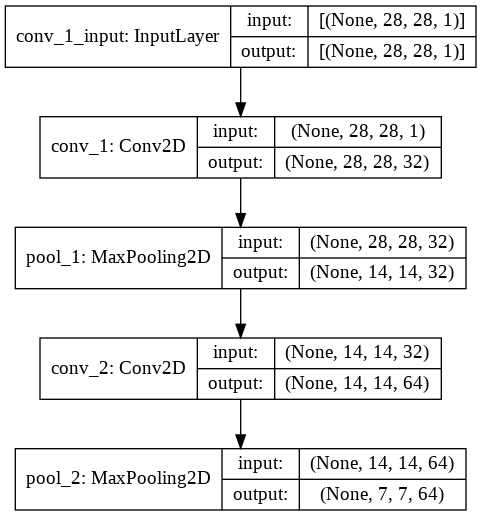

In [ ]:
model.build(input_shape=(None, 28, 28, 1))
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

### 2.2.2. 분류 레이어 모듈 설정

In [ ]:
model.add(tf.keras.layers.Flatten())

In [ ]:
model.compute_output_shape(input_shape=(None, 28, 28, 1))

TensorShape([None, 3136])

In [ ]:
model.add(tf.keras.layers.Dense(
    units=1024, 
    name='fc_1', 
    activation='relu'))
    
model.add(tf.keras.layers.Dense(
    units=10,
    name='fc_2',
    activation='softmax'))

In [ ]:
model.compute_output_shape(input_shape=(None, 28, 28, 1))

TensorShape([None, 10])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 14, 14, 64)        51264     
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
fc_1 (Dense)                 (None, 1024)              3212288   
_________________________________________________________________
fc_2 (Dense)                 (None, 10)                1

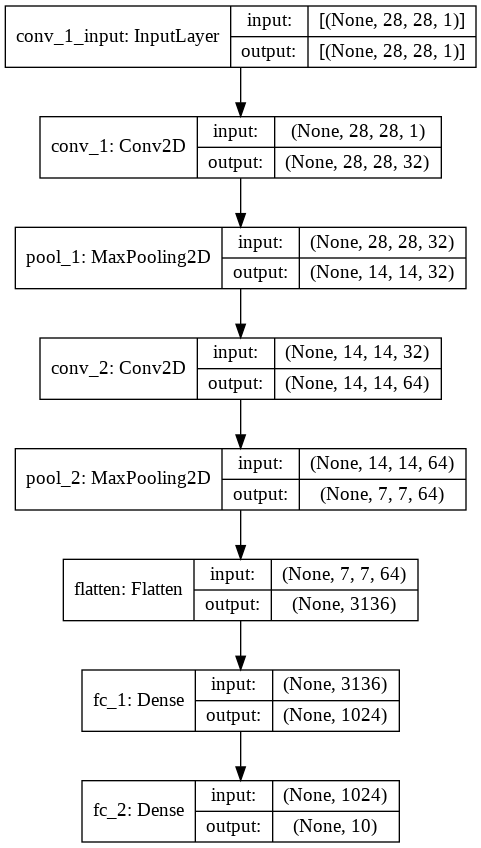

In [ ]:
model.build(input_shape=(None, 28, 28, 1))
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

### 2.2.3. CNN 모델 구성 및 실험

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), strides=(2, 2), padding='same', name='conv_1',  activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_1'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same', name='conv_2',  activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=512, name='fc_1', activation='relu'))
model.add(tf.keras.layers.Dense(units=10, name='fc_2', activation='softmax'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=20, 
                    validation_data=(X_valid,y_valid))

Epoch 1/20
1719/1719 [==============================] - 37s 3ms/step - loss: 0.5703 - accuracy: 0.7916 - val_loss: 0.3613 - val_accuracy: 0.8704
Epoch 2/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3856 - accuracy: 0.8601 - val_loss: 0.3200 - val_accuracy: 0.8794
Epoch 3/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3412 - accuracy: 0.8753 - val_loss: 0.2767 - val_accuracy: 0.8972
Epoch 4/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3119 - accuracy: 0.8849 - val_loss: 0.2666 - val_accuracy: 0.8970
Epoch 5/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2970 - accuracy: 0.8898 - val_loss: 0.2604 - val_accuracy: 0.8978
Epoch 6/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2806 - accuracy: 0.8968 - val_loss: 0.2615 - val_accuracy: 0.9028
Epoch 7/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2696 - accuracy: 0.8991 - val_loss: 0.2462 - val_accuracy

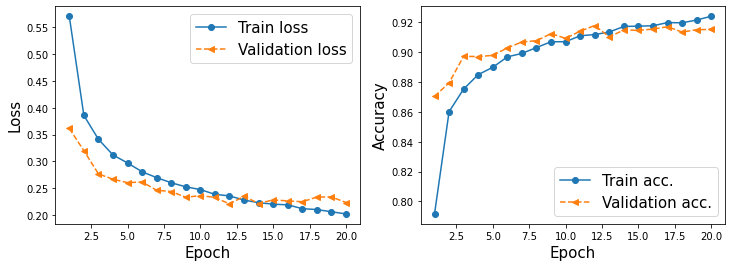

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [ ]:
test_results = model.evaluate(X_test, y_test)
print('\n테스트 정확도 {:.2f}%'.format(test_results[1]*100))

313/313 [==============================] - 1s 2ms/step - loss: 0.2444 - accuracy: 0.9099

테스트 정확도 90.99%


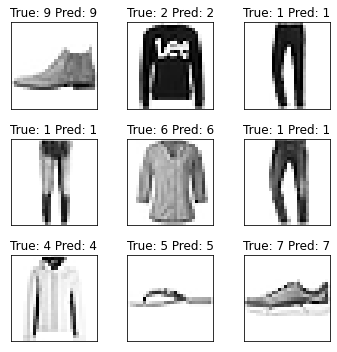

In [ ]:
#실제 이미지 분류 결과 확인 (맞는 경우)
y_test_pred = tf.argmax(model.predict(X_test), axis=1)
cl_img = X_test[y_test == y_test_pred][:9]
correct_lab = y_test[y_test == y_test_pred][:9]
cl_lab = y_test_pred[y_test == y_test_pred][:9]

fig, ax = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(5,5))
ax = ax.flatten()
for i in range(9):
    img = cl_img[i][:,:,0]
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('True: %d Pred: %d' % (correct_lab[i], cl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('images/12_09.png', dpi=300)
plt.show()

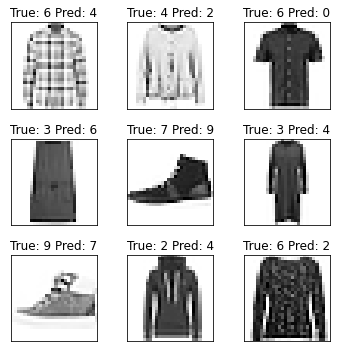

In [ ]:
#실제 이미지 분류 결과 확인 (틀린 경우)
y_test_pred = tf.argmax(model.predict(X_test), axis=1)
miscl_img = X_test[y_test != y_test_pred][:9]
correct_lab = y_test[y_test != y_test_pred][:9]
miscl_lab = y_test_pred[y_test != y_test_pred][:9]

fig, ax = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(5,5))
ax = ax.flatten()
for i in range(9):
    img = miscl_img[i][:,:,0]
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('True: %d Pred: %d' % (correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('images/12_09.png', dpi=300)
plt.show()

# [3] 응용1 - 컬러 이미지 분류하기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWiHcG646r5PxhQzDAnUw1zJLEnZ2mzmZhMFPHkaHN_U8NB7sE2S5vg
Mounted at /content/drive


## 3.1. 데이터셋 준비

cats_and_dog.zip 다운로드([링크](https://drive.google.com/uc?id=153ZpY4bTwht3vUL6oFapKiHl8Q1g_ZtE&export=download)) 후 cats_and_dogs 폴더에 업로드하기

In [ ]:
!pip install Image

     |████████████████████████████████| 7.9MB 6.7MB/s 
  Created wheel for Image: filename=image-1.5.33-py2.py3-none-any.whl size=19495 sha256=125522b6740a187a2f025c46b65e69fd8a1724bc4c1a97988b7a525d0493701d
  Stored in directory: /root/.cache/pip/wheels/87/4c/60/d5904e69c837fcdea7e03ffa0c657f35ced7e398c6f3ca17cc
Successfully built Image


In [ ]:
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!unzip '/content/drive/MyDrive/Colab Notebooks/cats_and_dogs.zip' -d cats_and_dogs

Archive:  /content/drive/MyDrive/Colab Notebooks/cats_and_dogs.zip
  inflating: cats_and_dogs/cat.0.jpg  
  inflating: cats_and_dogs/cat.1.jpg  
  inflating: cats_and_dogs/cat.10.jpg  
  inflating: cats_and_dogs/cat.100.jpg  
  inflating: cats_and_dogs/cat.1000.jpg  
  inflating: cats_and_dogs/cat.1001.jpg  
  inflating: cats_and_dogs/cat.1002.jpg  
  inflating: cats_and_dogs/cat.1003.jpg  
  inflating: cats_and_dogs/cat.1004.jpg  
  inflating: cats_and_dogs/cat.1005.jpg  
  inflating: cats_and_dogs/cat.1006.jpg  
  inflating: cats_and_dogs/cat.1007.jpg  
  inflating: cats_and_dogs/cat.1008.jpg  
  inflating: cats_and_dogs/cat.1009.jpg  
  inflating: cats_and_dogs/cat.101.jpg  
  inflating: cats_and_dogs/cat.1010.jpg  
  inflating: cats_and_dogs/cat.1011.jpg  
  inflating: cats_and_dogs/cat.1012.jpg  
  inflating: cats_and_dogs/cat.1013.jpg  
  inflating: cats_and_dogs/cat.1014.jpg  
  inflating: cats_and_dogs/cat.1015.jpg  
  inflating: cats_and_dogs/cat.1016.jpg  
  inflating: cats_a

In [ ]:
Image('/content/cats_and_dogs/cat.1.jpg')

TypeError: ignored

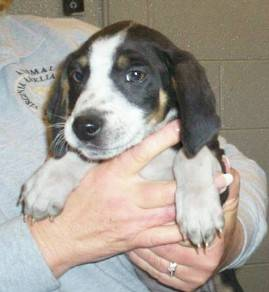

In [ ]:
Image('/content/cats_and_dogs/dog.10.jpg')

In [4]:
base_dir = './cats_and_dogs'

# 훈련, 검증, 테스트 분할을 위한 디렉터리
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# 훈련용 고양이 사진 디렉터리
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# 훈련용 강아지 사진 디렉터리
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# 검증용 고양이 사진 디렉터리
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# 검증용 강아지 사진 디렉터리
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# 테스트용 고양이 사진 디렉터리
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# 테스트용 강아지 사진 디렉터리
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

In [5]:
# 처음 1,000개의 고양이 이미지를 train_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(base_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# 다음 500개 고양이 이미지를 validation_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(base_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 고양이 이미지를 test_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(base_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 처음 1,000개의 강아지 이미지를 train_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(base_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 validation_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(base_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 test_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(base_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 모든 이미지를 1/255로 스케일을 조정합니다
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지를 150 × 150 크기로 바꿉니다
        target_size=(150, 150),
        batch_size=32,
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블이 필요합니다
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (32, 150, 150, 3)
배치 레이블 크기: (32, 2)


## 3.2. CNN 모델 학습하기

In [12]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3)))
model.add(tf.keras.layers.MaxPooling2D((3, 3)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)            

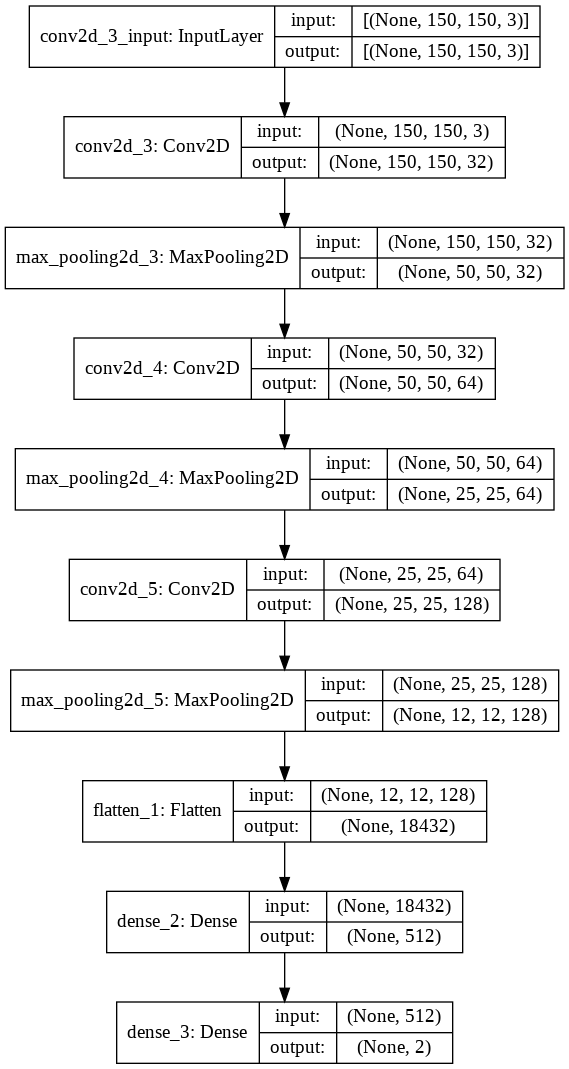

In [13]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model.fit(
      train_generator,
      epochs=30,
      validation_data=validation_generator)

Epoch 1/30
63/63 [==============================] - 41s 144ms/step - loss: 0.7467 - accuracy: 0.5255 - val_loss: 0.6884 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 9s 140ms/step - loss: 0.6837 - accuracy: 0.5480 - val_loss: 0.6550 - val_accuracy: 0.6230
Epoch 3/30
63/63 [==============================] - 9s 139ms/step - loss: 0.6284 - accuracy: 0.6475 - val_loss: 0.6786 - val_accuracy: 0.5460
Epoch 4/30
63/63 [==============================] - 9s 138ms/step - loss: 0.5870 - accuracy: 0.6785 - val_loss: 0.6447 - val_accuracy: 0.6430
Epoch 5/30
63/63 [==============================] - 9s 136ms/step - loss: 0.5258 - accuracy: 0.7435 - val_loss: 0.5957 - val_accuracy: 0.6750
Epoch 6/30
63/63 [==============================] - 9s 135ms/step - loss: 0.5018 - accuracy: 0.7590 - val_loss: 0.6738 - val_accuracy: 0.6650
Epoch 7/30
63/63 [==============================] - 8s 134ms/step - loss: 0.4193 - accuracy: 0.8070 - val_loss: 0.6090 - val_accuracy: 0.7090
Epoch

In [ ]:
model.save('cats_and_dogs_default.h5') #모델 저장
#model = tf.keras.models.load_model('cats_and_dogs_default.h5') #모델 로드

## 3.3. 성능 확인하기 - 과대적합?

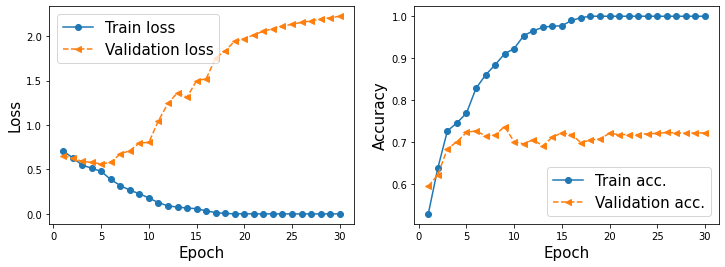

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [15]:
test_results = model.evaluate(test_generator)
print('\n테스트 정확도 {:.2f}%'.format(test_results[1]*100))

32/32 [==============================] - 3s 81ms/step - loss: 2.0095 - accuracy: 0.7440

테스트 정확도 74.40%


In [ ]:
# 드롭아웃 적용

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3)))
model.add(tf.keras.layers.MaxPooling2D((3, 3)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5)) #드랍아웃 적용
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model.fit(
      train_generator,
      epochs=30,
      validation_data=validation_generator)

Epoch 1/30
63/63 [==============================] - 9s 135ms/step - loss: 0.7046 - accuracy: 0.5150 - val_loss: 0.6790 - val_accuracy: 0.6010
Epoch 2/30
63/63 [==============================] - 8s 132ms/step - loss: 0.6717 - accuracy: 0.5780 - val_loss: 0.6598 - val_accuracy: 0.6080
Epoch 3/30
63/63 [==============================] - 8s 133ms/step - loss: 0.6159 - accuracy: 0.6515 - val_loss: 0.5855 - val_accuracy: 0.6970
Epoch 4/30
63/63 [==============================] - 8s 134ms/step - loss: 0.5890 - accuracy: 0.6810 - val_loss: 0.6090 - val_accuracy: 0.6710
Epoch 5/30
63/63 [==============================] - 8s 135ms/step - loss: 0.5480 - accuracy: 0.7240 - val_loss: 0.5785 - val_accuracy: 0.7000
Epoch 6/30
63/63 [==============================] - 8s 132ms/step - loss: 0.5026 - accuracy: 0.7510 - val_loss: 0.5397 - val_accuracy: 0.7430
Epoch 7/30
63/63 [==============================] - 8s 135ms/step - loss: 0.4762 - accuracy: 0.7710 - val_loss: 0.5532 - val_accuracy: 0.7090
Epoch 

In [ ]:
test_results = model.evaluate(test_generator)
print('\n테스트 정확도 {:.2f}%'.format(test_results[1]*100))

32/32 [==============================] - 3s 81ms/step - loss: 1.3037 - accuracy: 0.7300

테스트 정확도 73.00%


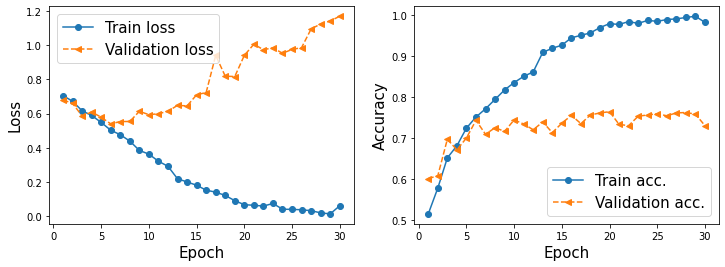

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

## 3.4. 데이터 증식하기

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_aug_gen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40, #랜덤하게 사진을 회전시킬 각도 범위(0-180 사이)
      width_shift_range=0.2,#사진을 수평으로 랜덤하게 평행 이동시킬 범위(전체 넓이에 대한 비율).
      height_shift_range=0.2, #사진을 수직으로 랜덤하게 평행 이동시킬 범위(전체 높이에 대한 비율).
      shear_range=0.2, #사진을 랜덤하게 전단(비틀기)할 각도 범위
      zoom_range=0.2, #사진을 랜덤하게 확대할 범위
      horizontal_flip=True, #랜덤하게 이미지를 수평으로 뒤집습니다. 수평 대칭을 가정할 수 있을 때 사용(예를 들어, 풍경/인물 사진)
      fill_mode='nearest') #회전이나 가로/세로 이동으로 인해 새롭게 생성해야 할 픽셀을 채우는 방법.

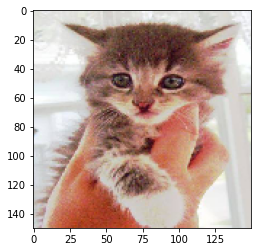

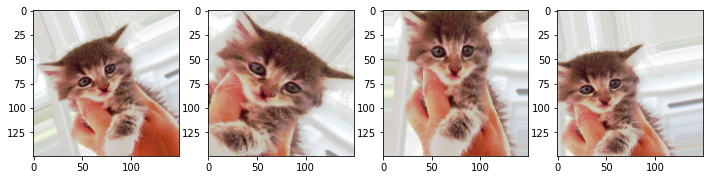

In [ ]:
# 이미지 전처리 유틸리티 모듈
from tensorflow.keras.preprocessing import image

fnames = sorted([os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)])

# 증식할 이미지 선택합니다
img_path = fnames[3]

# 이미지를 읽고 크기를 변경합니다
img = image.load_img(img_path, target_size=(150, 150))

# 이미지를 확인합니다.
plt.imshow(img)

# (150, 150, 3) 크기의 넘파이 배열로 변환합니다
x = image.img_to_array(img)

# (1, 150, 150, 3) 크기로 변환합니다
x = x.reshape((1,) + x.shape)

# flow() 메서드는 랜덤하게 변환된 이미지의 배치를 생성합니다.
# 무한 반복되기 때문에 어느 지점에서 중지해야 합니다!
i = 0
fig = plt.figure(figsize=(12, 4))
for batch in data_aug_gen.flow(x, batch_size=1):
    ax = fig.add_subplot(1, 4, i+1)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [ ]:
#데이터 증식하는 data_aug_gen으로 train data augmented generator 정의
train_aug_generator = data_aug_gen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 2000 images belonging to 2 classes.


In [ ]:
#모델 선언

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3)))
model.add(tf.keras.layers.MaxPooling2D((3, 3)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5)) #드랍아웃 적용
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
      train_aug_generator, #train data augmented generator
      epochs=50,
      validation_data=validation_generator)

Epoch 1/50
63/63 [==============================] - 17s 257ms/step - loss: 0.7085 - accuracy: 0.5085 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 16s 250ms/step - loss: 0.6943 - accuracy: 0.5035 - val_loss: 0.6918 - val_accuracy: 0.5000
Epoch 3/50
63/63 [==============================] - 16s 250ms/step - loss: 0.6920 - accuracy: 0.5225 - val_loss: 0.6829 - val_accuracy: 0.5000
Epoch 4/50
63/63 [==============================] - 16s 250ms/step - loss: 0.6910 - accuracy: 0.4935 - val_loss: 0.6831 - val_accuracy: 0.5660
Epoch 5/50
63/63 [==============================] - 16s 253ms/step - loss: 0.6902 - accuracy: 0.5245 - val_loss: 0.6838 - val_accuracy: 0.5560
Epoch 6/50
63/63 [==============================] - 16s 250ms/step - loss: 0.6936 - accuracy: 0.4930 - val_loss: 0.6913 - val_accuracy: 0.5000
Epoch 7/50
63/63 [==============================] - 16s 250ms/step - loss: 0.6917 - accuracy: 0.5245 - val_loss: 0.6849 - val_accuracy: 0.5510

In [ ]:
model.save('cats_and_dogs_augmented.h5')

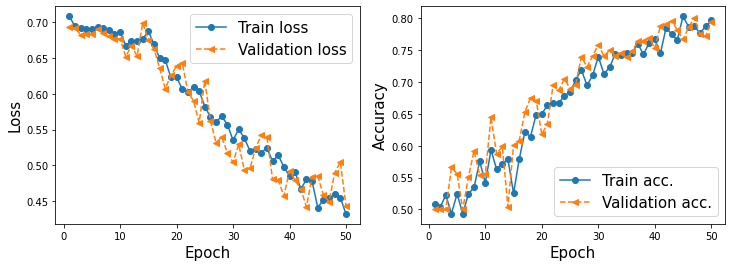

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [ ]:
test_results = model.evaluate(test_generator)
print('\n테스트 정확도 {:.2f}%'.format(test_results[1]*100))

32/32 [==============================] - 3s 80ms/step - loss: 0.4737 - accuracy: 0.7820

테스트 정확도 78.20%


# [4] 응용2 - 트랜스퍼 러닝

In [ ]:
Image(url='https://camo.githubusercontent.com/2de162f6f3587a0422389355909594413ae17742/68747470733a2f2f73332e616d617a6f6e6177732e636f6d2f626f6f6b2e6b657261732e696f2f696d672f6368352f7377617070696e675f66635f636c61737369666965722e706e67', width=600)

## 4.1. VGG16 신경망 불러오기

In [ ]:
Image(url='https://blog.kakaocdn.net/dn/K990l/btqwDJ7C54R/664Ksm6gyTGBR1wK3YPDFk/img.png')

NameError: ignored

ImageNet 데이터셋에 훈련된 VGG16 네트워크의 합성곱 기반층을 사용하여 강아지와 고양이 이미지에서 유용한 특성을 추출

In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', #모델을 초기화할 가중치 체크포인트를 지정
                  include_top=False, #신경망 최상위의 분류기를 불러올지 여부 결정 (기본은 Imagenet의 1000개 클래스 구분 분류기)
                  input_shape=(150, 150, 3)) #입력 이미지 크기

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## 4.2. two-step 활용: 베이스 모델 특징 추출 -> 분류 모델 훈련

### 4.2.1. 베이스 모델로 특징 추출

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = 'cats_and_dogs'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch) #conv_base를 이용해 특징 추출 (inference 과정만 거침)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count: # sample_count만큼 처리하고 중지
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### 4.2.2. 분류 모델로 훈련

In [ ]:
# 완전 연결 분류기에 주입하기 위해 평탄화 -> (samples, 4 * 4 * 512 = 8192) 크기로 펼침
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [ ]:
# 분류기 정의 및 훈련
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
63/63 [==============================] - 1s 8ms/step - loss: 0.5370 - accuracy: 0.7775 - val_loss: 0.2701 - val_accuracy: 0.8840
Epoch 2/30
63/63 [==============================] - 0s 7ms/step - loss: 0.2541 - accuracy: 0.8955 - val_loss: 0.2595 - val_accuracy: 0.9040
Epoch 3/30
63/63 [==============================] - 0s 6ms/step - loss: 0.1964 - accuracy: 0.9235 - val_loss: 0.2946 - val_accuracy: 0.8840
Epoch 4/30
63/63 [==============================] - 0s 7ms/step - loss: 0.1732 - accuracy: 0.9240 - val_loss: 0.2472 - val_accuracy: 0.9040
Epoch 5/30
63/63 [==============================] - 0s 6ms/step - loss: 0.1262 - accuracy: 0.9515 - val_loss: 0.2416 - val_accuracy: 0.9030
Epoch 6/30
63/63 [==============================] - 0s 7ms/step - loss: 0.1132 - accuracy: 0.9540 - val_loss: 0.3707 - val_accuracy: 0.8600
Epoch 7/30
63/63 [==============================] - 0s 7ms/step - loss: 0.0860 - accuracy: 0.9690 - val_loss: 0.2684 - val_accuracy: 0.9000
Epoch 8/30
63/63 [==

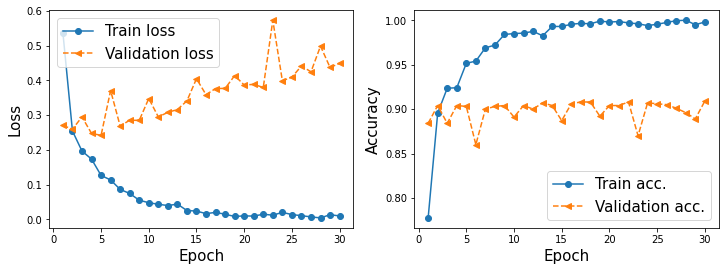

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [ ]:
test_results = model.evaluate(test_features, test_labels)
print('\n테스트 정확도 {:.2f}%'.format(test_results[1]*100))

32/32 [==============================] - 0s 3ms/step - loss: 0.5195 - accuracy: 0.8840

테스트 정확도 88.40%


## 4.3. end-to-end 활용: 베이스모델(전체동결)+분류모델 훈련

In [ ]:
model = tf.keras.models.Sequential()
model.add(conv_base) # 베이스 모델
#분류 모델 추가
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary() #trainable params는 1681만 개

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
conv_base.trainable = False #베이스 모델은 훈련되지 않도록 동결 (freezing) - 동결하지 않을 시 분류 모델의 큰 에러가 역전파되어 베이스 모델이 불안정해짐

In [ ]:
model.summary() #trainable params가 209만개로 감소

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
#모델 훈련

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
      train_aug_generator, #학습 데이터 증식 제네레이터
      epochs=30,
      validation_data=validation_generator)

Epoch 1/30
63/63 [==============================] - 24s 376ms/step - loss: 0.5283 - accuracy: 0.7460 - val_loss: 0.2795 - val_accuracy: 0.8870
Epoch 2/30
63/63 [==============================] - 23s 370ms/step - loss: 0.4010 - accuracy: 0.8180 - val_loss: 0.3114 - val_accuracy: 0.8600
Epoch 3/30
63/63 [==============================] - 23s 372ms/step - loss: 0.3791 - accuracy: 0.8235 - val_loss: 0.2660 - val_accuracy: 0.8800
Epoch 4/30
63/63 [==============================] - 23s 368ms/step - loss: 0.3454 - accuracy: 0.8385 - val_loss: 0.2639 - val_accuracy: 0.8920
Epoch 5/30
63/63 [==============================] - 23s 364ms/step - loss: 0.3298 - accuracy: 0.8565 - val_loss: 0.2580 - val_accuracy: 0.9020
Epoch 6/30
63/63 [==============================] - 23s 361ms/step - loss: 0.3555 - accuracy: 0.8385 - val_loss: 0.2576 - val_accuracy: 0.8920
Epoch 7/30
63/63 [==============================] - 23s 362ms/step - loss: 0.3081 - accuracy: 0.8610 - val_loss: 0.2468 - val_accuracy: 0.9040

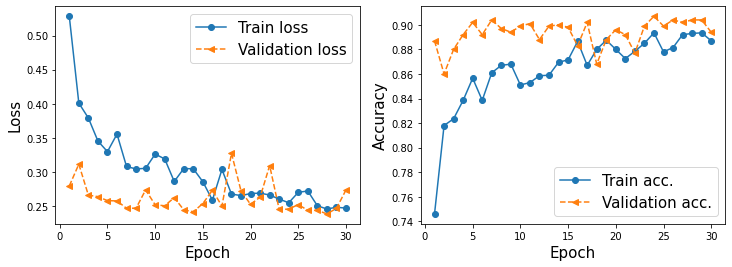

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [ ]:
test_results = model.evaluate(test_generator)
print('\n테스트 정확도 {:.2f}%'.format(test_results[1]*100))

32/32 [==============================] - 5s 142ms/step - loss: 0.2924 - accuracy: 0.8660

테스트 정확도 86.60%


In [ ]:
model.save('cats_and_dogs_vgg16_fc_e2e.h5')

## 4.4. 미세 조정 end-to-end 활용: 베이스모델(일부동결)+분류모델(일부학습) 훈련

In [ ]:
Image(url='https://camo.githubusercontent.com/28a6cb7048317aba34f39cb02f15520708189008/68747470733a2f2f73332e616d617a6f6e6177732e636f6d2f626f6f6b2e6b657261732e696f2f696d672f6368352f76676731365f66696e655f74756e696e672e706e67')

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
conv_base.trainable = True
#베이스 모델의 block5(3개의 합성곱층+풀링)만 동결 해제
for layer in conv_base.layers:
    if layer.name in ['block5_conv1','block5_conv2','block5_conv3']:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
conv_base.summary() #trainable params가 2359808 * 3 = 7,079,424으로 변경

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
model.summary() #미세 조정 훈련시킬 전체 모델 (분류 모델 부분은 이미 일부 학습되어 있음)
#trainable params: 209만개 -> 917만개로 증가 (베이스 모델의 708만개 추가)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), #기존에 학습된 가중치를 과하게 조정하지 않기 위해 학습률을 낮춤 (기본 = 1e-3)
              metrics=['accuracy'])

history = model.fit(
      train_aug_generator, #학습 데이터 증식 제네레이터
      epochs=30,
      validation_data=validation_generator)

Epoch 1/30
63/63 [==============================] - 25s 386ms/step - loss: 0.2376 - accuracy: 0.8945 - val_loss: 0.2325 - val_accuracy: 0.9130
Epoch 2/30
63/63 [==============================] - 24s 381ms/step - loss: 0.2248 - accuracy: 0.8980 - val_loss: 0.2278 - val_accuracy: 0.9100
Epoch 3/30
63/63 [==============================] - 24s 378ms/step - loss: 0.1811 - accuracy: 0.9240 - val_loss: 0.2169 - val_accuracy: 0.9150
Epoch 4/30
63/63 [==============================] - 24s 375ms/step - loss: 0.1781 - accuracy: 0.9275 - val_loss: 0.2071 - val_accuracy: 0.9140
Epoch 5/30
63/63 [==============================] - 24s 376ms/step - loss: 0.1776 - accuracy: 0.9255 - val_loss: 0.2061 - val_accuracy: 0.9170
Epoch 6/30
63/63 [==============================] - 24s 376ms/step - loss: 0.1496 - accuracy: 0.9365 - val_loss: 0.2118 - val_accuracy: 0.9240
Epoch 7/30
63/63 [==============================] - 24s 377ms/step - loss: 0.1489 - accuracy: 0.9395 - val_loss: 0.2209 - val_accuracy: 0.9160

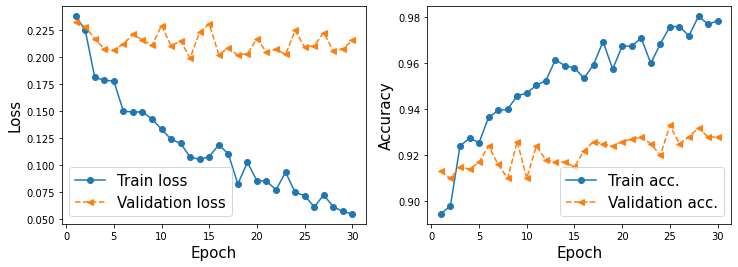

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [ ]:
test_results = model.evaluate(test_generator)
print('\n테스트 정확도 {:.2f}%'.format(test_results[1]*100))

32/32 [==============================] - 5s 142ms/step - loss: 0.2094 - accuracy: 0.9320

테스트 정확도 93.20%


# [5] 응용3 - CNN 학습 시각화

## 5.1. 모델 및 입력 데이터 준비

In [ ]:
# 증식 데이터를 활용해 학습한 기본 모델을 로딩
model = tf.keras.models.load_model('cats_and_dogs_augmented.h5')
model.summary()  

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 256)      

(1, 150, 150, 3)


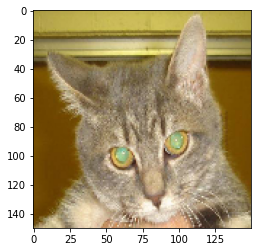

In [ ]:
from tensorflow.keras.preprocessing import image

# 임의의 사진 선택
img_path = 'cats_and_dogs/test/cats/cat.1770.jpg'

# 동일한 전처리 방식 적용
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)
plt.imshow(img_tensor[0])
plt.show()

## 5.2. 은닉층의 출력값 반환 모델 생성

In [ ]:
# 상위 6개 층의 출력 부분을 모음
layer_outputs = [layer.output for layer in model.layers[:6]]
# 입력에 대해 상위 6개 층의 출력을 반환하는 모델 생성
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
# 위에서 생성한 상위 6개층 출력 반환 모델을 사용하여 입력 이미지의 각각 층에서의 출력값 얻음
activations = activation_model.predict(img_tensor)

In [ ]:
for activation in activations:
  print(activation.shape)

(1, 150, 150, 32)
(1, 50, 50, 32)
(1, 50, 50, 64)
(1, 25, 25, 64)
(1, 25, 25, 128)
(1, 12, 12, 128)


## 5.3. 입력 데이터에 대한 각 은닉층의 출력값 확인

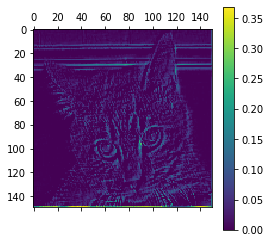

In [ ]:
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')
plt.colorbar()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


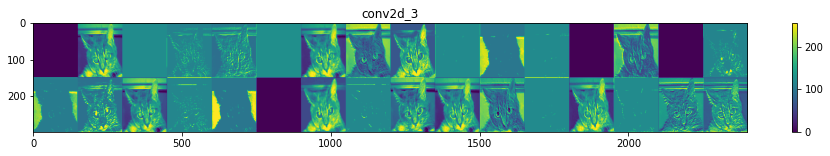

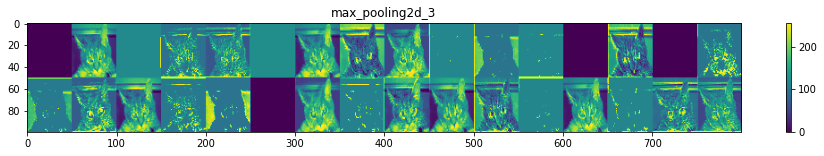

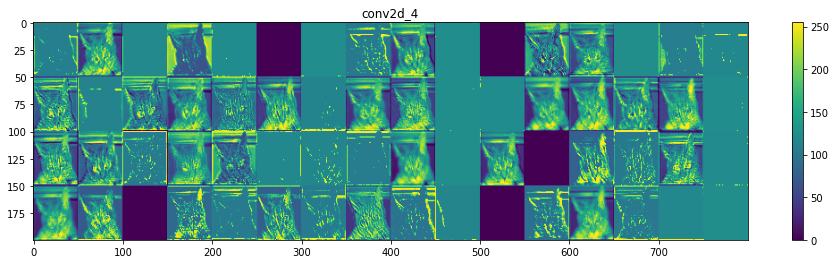

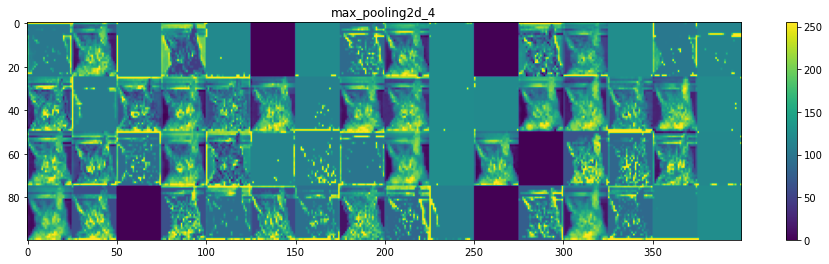

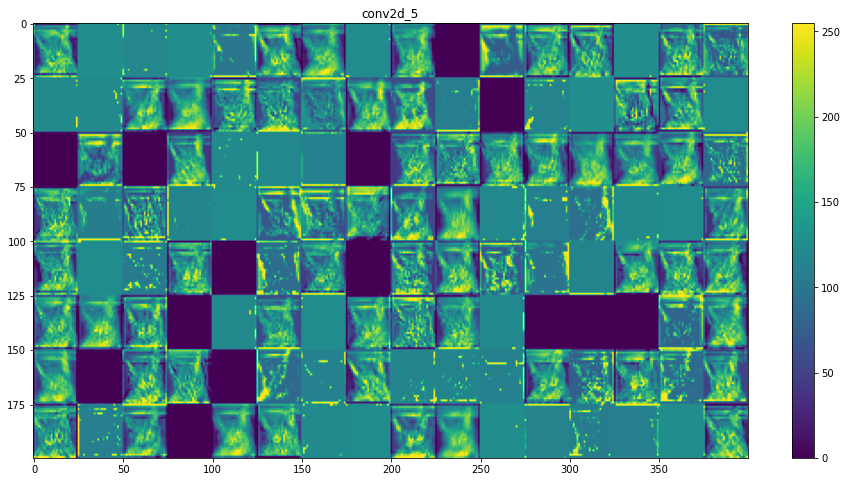

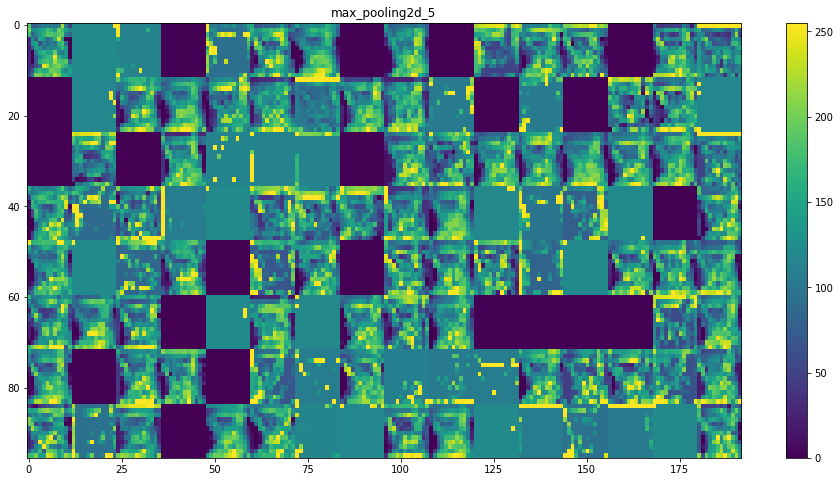

In [ ]:
# 층의 이름을 그래프 제목으로 사용합니다
layer_names = []
for layer in model.layers[:6]:
    layer_names.append(layer.name)

images_per_row = 16

# 특성 맵을 그립니다
for layer_name, layer_activation in zip(layer_names, activations):
    # 특성 맵에 있는 특성의 수
    n_features = layer_activation.shape[-1]

    # 특성 맵의 크기는 (1, size, size, n_features)입니다
    size = layer_activation.shape[1]

    # 활성화 채널을 위한 그리드 크기를 구합니다
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # 각 활성화를 하나의 큰 그리드에 채웁니다
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # 그래프로 나타내기 좋게 특성을 처리합니다
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # 그리드를 출력합니다
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.colorbar()

plt.show()

## 5.4. 히트맵

(1, 150, 150, 3)


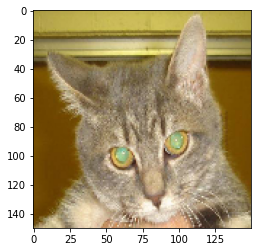

강아지 확률 49.19%
고양이 확률 50.81%


In [ ]:
from tensorflow.keras.preprocessing import image

# 임의의 사진 선택
img_path = 'cats_and_dogs/test/cats/cat.1770.jpg' 
#img_path = 'cats_and_dogs/test/dogs/dog.1550.jpg' 

# 동일한 전처리 방식 적용
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)
plt.imshow(img_tensor[0])
plt.show()

preds = model.predict(img_tensor)
print('강아지 확률 {:.2f}%'.format(preds[0][0]*100))
print('고양이 확률 {:.2f}%'.format((1-preds[0][0])*100))

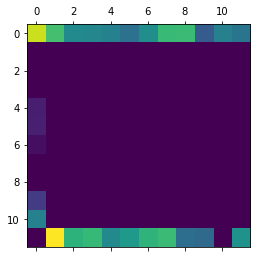

In [ ]:
#모델의 마지막 합성곱층 
last_conv_layer = model.get_layer('conv2d_6')

heatmap_model = tf.keras.models.Model([model.input] , [last_conv_layer.output , model.output])

with tf.GradientTape() as gtape:
    
    conv_output, predictions = heatmap_model(img_tensor)
    
    # 가장 가능성이 높은 클래스에 대한 정보에서 loss 파악
    loss = predictions[:, np.argmax(predictions[0])]
    
    # block5_conv3의 특성 맵 출력에 대한 'groenendael' 클래스의 그래디언트
    grads = gtape.gradient(loss, conv_output)
    
    # 특성 맵 채널별 그래디언트 평균값이 담긴 벡터
    pooled_grads = tf.keras.backend.mean(grads, axis=(0, 1, 2))

# 특성 맵의 출력
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)

# 0 ~ 1 사이의 값으로 정규화
heatmap = np.maximum(heatmap, 0)

max_heat = np.max(heatmap)

if max_heat == 0:
    max_heat = 1e-10
    
heatmap /= max_heat

plt.matshow(heatmap[0]);

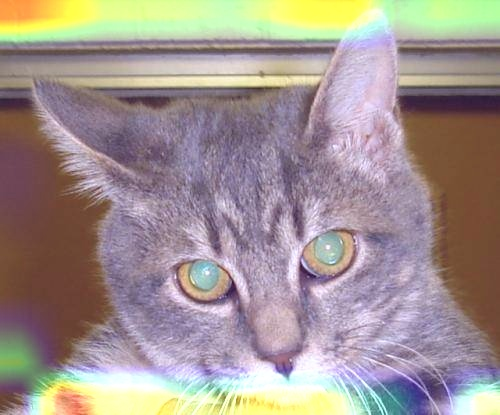

In [ ]:
import cv2

org_Image = cv2.imread(img_path)

height , width , channel = org_Image.shape

# heatmap을 원본 이미지 사이즈에 맞춘다
heatmap_Resized = cv2.resize(heatmap[0]  , (width , height))

# 값을 0 ~ 255 사이 int 형으로 변경 // RGB 형식
heatmap_Resized = np.uint8(255 * heatmap_Resized)

# heatmap으로 변환
heatmap_Resized = cv2.applyColorMap(heatmap_Resized , cv2.COLORMAP_JET)

superimposed_img = heatmap_Resized * 0.4 + org_Image

cv2.imwrite('./heatmap_Result.jpg' , superimposed_img)
Image('./heatmap_Result.jpg')